In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [164]:
#This code uses excel file maps of strains and conditions on a plate to read excel files with Spark data output.

In [165]:
#Define function to read data in
#Layout will depend on the plate reader used

cell_spacing = 61  #cell_spacing is the number of cells between measurements (depends on Spark settings)
MRPW_stagger = 0  #used if measuring multiple reads per well

def make_array(file_name):
        
    data = pd.read_excel(file_name)
    
    time_points = int(round((len(data)+1)/cell_spacing))    
    od_array    = np.zeros((8,12,time_points))
    fl_array    = np.zeros((8,12,time_points))

    for i in range(time_points):
        od_index_start = MRPW_stagger+3 + i*cell_spacing
        od_index_end   = MRPW_stagger+11 + i*cell_spacing
        
        fl_index_start = MRPW_stagger+13 + i*cell_spacing
        fl_index_end   = MRPW_stagger+21 + i*cell_spacing
        
        fl = data.iloc[fl_index_start:fl_index_end,1:13]
        
        for j in range(len(fl.iloc[:,0])):
            for k in range(len(fl.iloc[0,:])):
                s = fl.iloc[j,k]
                if type(s) == str:
                    fl.iloc[j,k] = float(s.replace("~","")) #clean "~" from fluorescence values
        
        
        od_array[:,:,i] = data.iloc[od_index_start:od_index_end,1:13].values
        fl_array[:,:,i] = fl.values[:,:]
        
    return od_array, fl_array

In [166]:
#specify data to read in

#data files to read in
datafile = 'Example_data.xlsx'
od_array, fl_array = make_array(datafile)

#maps to read in
mapfile = 'Example_map.xlsx'
mapsheet = pd.read_excel(mapfile) 

#specify which parts of the map files to use
strainID_array    = mapsheet.to_numpy()[2:10,1:13]
strainname_array    = mapsheet.to_numpy()[12:20,1:13]
conditionname_array    = mapsheet.to_numpy()[22:30,1:13]

In [167]:
#Make 2d arrays
#maps
strainID_array_ord = [strainID_array[j, k] for j in range(8) for k in range(12)]
strainname_array_ord = [strainname_array[j, k] for j in range(8) for k in range(12)]
conditionname_array_ord = [conditionname_array[j, k] for j in range(8) for k in range(12)]
        
#Data     
od_array_ord = [od_array[j, k].tolist() for j in range(8) for k in range(12)]
fl_array_ord = [fl_array[j, k].tolist() for j in range(8) for k in range(12)]

In [168]:
#make a dataframe with all the values
df = pd.DataFrame({'StrainID': strainID_array_ord,
                          'StrainName': strainname_array_ord,
                          'Condition': conditionname_array_ord,
                          'Fluor': fl_array_ord,
                          'OD': od_array_ord})

#make a dataframe that combines replicates to generate averages and standard error

# Group by 'StrainName' and 'Condition' and calculate the average and standard error of 'Fluor' lists
avg_df = df.groupby(['StrainName', 'Condition']).agg({'Fluor': lambda x: [np.mean(values) for values in zip(*x)],
                                                     'OD': lambda x: [np.mean(values) for values in zip(*x)]}).reset_index()
# Calculate standard error of 'Fluor' and 'OD'
avg_df['StdErrorFluor'] = df.groupby(['StrainName', 'Condition'])['Fluor'].apply(lambda x: [np.std(values) / np.sqrt(len(values)) for values in zip(*x)]).reset_index()['Fluor']
avg_df['StdErrorOD'] = df.groupby(['StrainName', 'Condition'])['OD'].apply(lambda x: [np.std(values) / np.sqrt(len(values)) for values in zip(*x)]).reset_index()['OD']

# Rename the columns
avg_df.rename(columns={'Fluor': 'AvgFluor', 'OD': 'AvgOD'}, inplace=True)

In [180]:
#print all the unique strain names
print("Strains :" + str(set(strainname_array_ord)))

Strains :{'Negative', 'Strain 2', 'Strain 3', 'Strain 5', 'Strain 4', 'Strain 6', 'blank', 'Strain 7', 'Strain 1'}


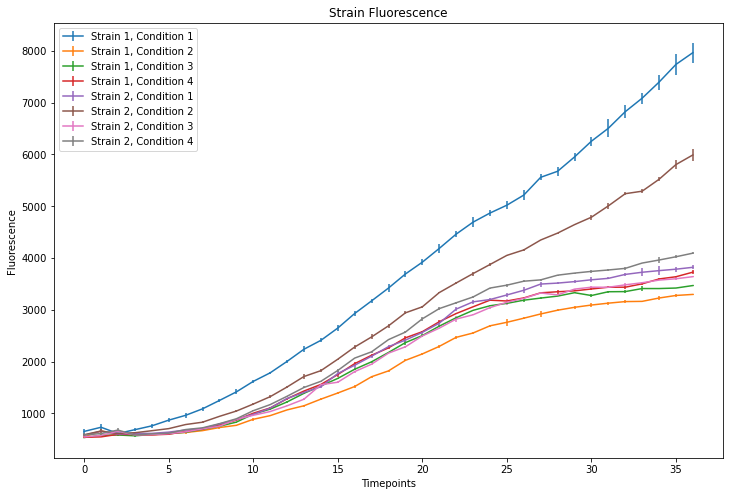

In [172]:
#Plot fluorescence of selected strains
strains_to_plot = ['Strain 1', 'Strain 2']

# Filter the dataframe based on StrainName label
filtered_df = avg_df[avg_df['StrainName'].isin(strains_to_plot)]

#set the plot size
plt.figure(figsize=(12, 8))

# Iterate over each row in the filtered dataframe and plot the data with error bars
for index, row in filtered_df.iterrows():
    x = range(0, len(row['AvgFluor']))
    y = row['AvgFluor']
    error = row['StdErrorFluor']
    plt.errorbar(x, y, yerr=error, fmt='-', label=(row['StrainName']+", "+row['Condition']))

# Add plot labels and legend
plt.xlabel('Timepoints')
plt.ylabel('Fluorescence')
plt.legend()
plt.title("Strain Fluorescence")

# Display the plot
plt.show()

In [183]:
#how many timepoints in the experiment?
print("Timepoints: " +str(len(fl_array[0][0]))) 

#print all the unique condition names
print("Conditions :" + str(set(conditionname_array_ord)))

Timepoints: 37
Conditions :{'Condition 4', 'Condition 3', 'Constant Light', 'Condition 2', 'Condition 1', 'Constant Dark'}


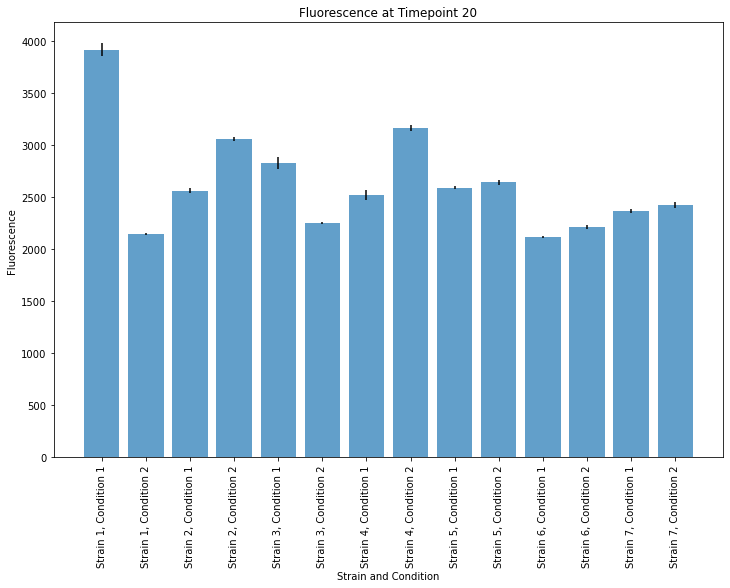

In [182]:
#Plot fluorescence for specific strains at selected timepoint

conditions_to_plot = ['Condition 1', 'Condition 2']  # Specify the conditions to plot

# Define the timepoint to plot
timepoint = 20 #the initial timepoint is timepoint 0

# Filter the dataframe based on StrainName label
filtered_df = avg_df[avg_df['Condition'].isin(conditions_to_plot)]

# Get the data and error values at the specified timepoint
data = filtered_df['AvgFluor'].apply(lambda x: x[timepoint])
error = filtered_df['StdErrorFluor'].apply(lambda x: x[timepoint])

# Set the x-axis values for the bar chart
x = range(len(filtered_df))

# Create the bar chart
plt.figure(figsize=(12, 8))
plt.bar(x, data, yerr=error, align='center', alpha=0.7)

# Set the x-axis tick labels
plt.xticks(x, filtered_df['StrainName'] + ', ' + filtered_df['Condition'], rotation=90)

# Add plot labels and title
plt.xlabel('Strain and Condition')
plt.ylabel('Fluorescence')
plt.title(f'Fluorescence at Timepoint {timepoint}')

# Display the plot
plt.show()
